In [76]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score
from hvae import HierarchicalVAE, loss_function
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score
import random



In [77]:
def train_models(X_train, X_test, y_test, input_dim, z1_list, z2_list, epoch_list, optimizer_type="adam"):

    # Normalize data
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test = y_test.astype(int)

    # DataLoader factory
    train_loader = lambda: DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

    results = []

    for z1_dim in z1_list:
        for z2_dim in z2_list:
            for epochs in epoch_list:
                model = HierarchicalVAE(input_dim, z1_dim, z2_dim)

                # Choose optimizer
                if optimizer_type.lower() == "adam":
                    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
                elif optimizer_type.lower() == "sgd":
                    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
                else:
                    raise ValueError("Unsupported optimizer: choose 'adam' or 'sgd'.")

                # Train loop
                model.train()
                for epoch in range(epochs):
                    for (x_batch,) in train_loader():
                        x_hat, mu_z1, logvar_z1, mu_z2, logvar_z2 = model(x_batch)
                        loss, _, _, _ = loss_function(x_batch, x_hat, mu_z1, logvar_z1, mu_z2, logvar_z2)

                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Evaluate
                recon_errors, auc = evaluate_model(model, X_test_tensor, y_test)

                results.append({
                    "z1_dim": z1_dim,
                    "z2_dim": z2_dim,
                    "epochs": epochs,
                    "optimizer": optimizer_type,
                    "auc": auc
                })

                print(f"z1: {z1_dim}, z2: {z2_dim}, epochs: {epochs}, opt: {optimizer_type.upper()} → AUC: {auc:.4f}")

    return results




In [78]:
def evaluate_model(model, X_test_tensor, y_test):

    model.eval()
    recon_errors = []

    with torch.no_grad():
        for x in X_test_tensor:
            x = x.unsqueeze(0)
            x_hat, _, _, _, _ = model(x)

            # Compute reconstruction error
            error = torch.mean((x - x_hat) ** 2).item()
            recon_errors.append(error)

    # check for NaNs
    recon_errors = np.array(recon_errors)

    if np.isnan(recon_errors).any():
        print("⚠️ Warning: NaN values detected in reconstruction errors. Skipping AUC.")
        return recon_errors, 0.0

    if len(recon_errors) != len(y_test):
        print("⚠️ Warning: Length mismatch between recon_errors and y_test.")
        return recon_errors, 0.0

    auc = roc_auc_score(y_test, recon_errors)
    return recon_errors, auc


In [79]:
f = np.load("cardio.npz")
X_train = f["x"]
X_test = f["tx"]
y_test = f["ty"]

In [80]:
#Data Normalization
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test = y_test.astype(int)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)
X_train = np.nan_to_num(X_train, nan=0.0, posinf=1.0, neginf=-1.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=1.0, neginf=-1.0)



In [81]:
import numpy as np

f = np.load("cardio.npz")
X_train = f["x"]
X_test = f["tx"]
y_test = f["ty"]
input_dim = X_train.shape[1]

results = train_models(
    X_train=X_train,
    X_test=X_test,
    y_test=y_test,
    input_dim=input_dim,
    z1_list=[4, 8, 16],
    z2_list=[2, 4, 8],
    epoch_list=[100, 200],
    optimizer_type="adam"
)


z1: 4, z2: 2, epochs: 100, opt: ADAM → AUC: 0.8519
z1: 4, z2: 2, epochs: 200, opt: ADAM → AUC: 0.8103
z1: 4, z2: 4, epochs: 100, opt: ADAM → AUC: 0.7888
z1: 4, z2: 4, epochs: 200, opt: ADAM → AUC: 0.8399
z1: 4, z2: 8, epochs: 100, opt: ADAM → AUC: 0.8153
z1: 4, z2: 8, epochs: 200, opt: ADAM → AUC: 0.8048
z1: 8, z2: 2, epochs: 100, opt: ADAM → AUC: 0.8014
z1: 8, z2: 2, epochs: 200, opt: ADAM → AUC: 0.7978
z1: 8, z2: 4, epochs: 100, opt: ADAM → AUC: 0.8451
z1: 8, z2: 4, epochs: 200, opt: ADAM → AUC: 0.7935
z1: 8, z2: 8, epochs: 100, opt: ADAM → AUC: 0.7668
z1: 8, z2: 8, epochs: 200, opt: ADAM → AUC: 0.8121
z1: 16, z2: 2, epochs: 100, opt: ADAM → AUC: 0.7676
z1: 16, z2: 2, epochs: 200, opt: ADAM → AUC: 0.7772
z1: 16, z2: 4, epochs: 100, opt: ADAM → AUC: 0.8254
z1: 16, z2: 4, epochs: 200, opt: ADAM → AUC: 0.7679
z1: 16, z2: 8, epochs: 100, opt: ADAM → AUC: 0.7467
z1: 16, z2: 8, epochs: 200, opt: ADAM → AUC: 0.7487


In [83]:
df_results = pd.DataFrame(results)
df_results.to_csv("hvae_grid_results.csv", index=False)

print("Results saved to hvae_grid_results.csv")

Results saved to hvae_grid_results.csv


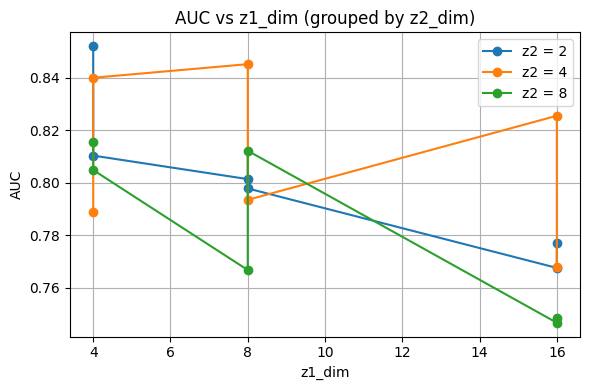

In [84]:
import matplotlib.pyplot as plt

# AUC vs z1_dim
plt.figure(figsize=(6, 4))
for z2 in sorted(df_results['z2_dim'].unique()):
    subset = df_results[df_results['z2_dim'] == z2]
    plt.plot(subset['z1_dim'], subset['auc'], marker='o', label=f'z2 = {z2}')
plt.xlabel("z1_dim")
plt.ylabel("AUC")
plt.title("AUC vs z1_dim (grouped by z2_dim)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


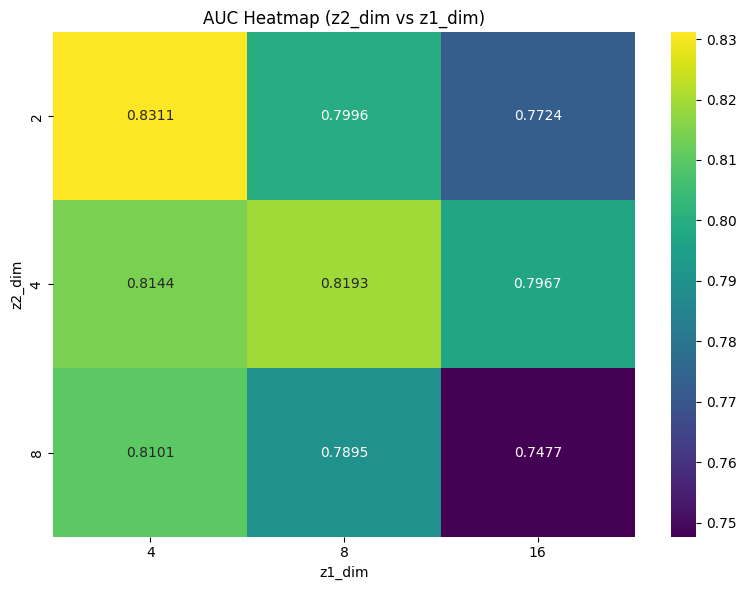

In [85]:
import seaborn as sns

# Pivot data for heatmap
pivot = df_results.pivot_table(index='z2_dim', columns='z1_dim', values='auc')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="viridis")
plt.title("AUC Heatmap (z2_dim vs z1_dim)")
plt.xlabel("z1_dim")
plt.ylabel("z2_dim")
plt.tight_layout()
plt.show()


In [86]:
top = df_results.sort_values(by="auc", ascending=False).head(5)
print("\nTop 5 configurations by AUC:")
print(top)



Top 5 configurations by AUC:
    z1_dim  z2_dim  epochs optimizer       auc
0        4       2     100      adam  0.851918
8        8       4     100      adam  0.845074
3        4       4     200      adam  0.839908
14      16       4     100      adam  0.825446
4        4       8     100      adam  0.815341


## Trying to automate the hyperparameter tuning


In [70]:

all_results = []

# Number of random experiments
num_experiments = 5  # You can increase this for more runs

for i in range(num_experiments):
    # Random hyperparameters for this experiment
    z1_list = random.sample([4, 8, 16, 32], k=random.randint(2, 4))
    z2_list = random.sample([2, 4, 8, 16], k=random.randint(2, 4))
    epoch_list = random.sample([50, 100, 200, 300], k=random.randint(1, 3))

    print(f"\n🔁 Experiment {i+1}/{num_experiments}")
    print(f"z1_list: {z1_list}, z2_list: {z2_list}, epoch_list: {epoch_list}")

    results = train_models(
        X_train=X_train,
        X_test=X_test,
        y_test=y_test,
        input_dim=input_dim,
        z1_list=z1_list,
        z2_list=z2_list,
        epoch_list=epoch_list,
        optimizer_type="adam"
    )

    all_results.extend(results)

# Save all results to CSV
df_all = pd.DataFrame(all_results)
df_all.to_csv("random_grid_results.csv", index=False)
print("All random experiments saved to random_grid_results.csv")


🔁 Experiment 1/5
z1_list: [8, 4, 32], z2_list: [2, 4, 16], epoch_list: [200, 100, 300]
z1: 8, z2: 2, epochs: 200, opt: ADAM → AUC: 0.8166
z1: 8, z2: 2, epochs: 100, opt: ADAM → AUC: 0.7562
z1: 8, z2: 2, epochs: 300, opt: ADAM → AUC: 0.8658
z1: 8, z2: 4, epochs: 200, opt: ADAM → AUC: 0.8310
z1: 8, z2: 4, epochs: 100, opt: ADAM → AUC: 0.7651
z1: 8, z2: 4, epochs: 300, opt: ADAM → AUC: 0.8158
z1: 8, z2: 16, epochs: 200, opt: ADAM → AUC: 0.7698
z1: 8, z2: 16, epochs: 100, opt: ADAM → AUC: 0.7912
z1: 8, z2: 16, epochs: 300, opt: ADAM → AUC: 0.7589
z1: 4, z2: 2, epochs: 200, opt: ADAM → AUC: 0.8512
z1: 4, z2: 2, epochs: 100, opt: ADAM → AUC: 0.8231
z1: 4, z2: 2, epochs: 300, opt: ADAM → AUC: 0.8504
z1: 4, z2: 4, epochs: 200, opt: ADAM → AUC: 0.7675
z1: 4, z2: 4, epochs: 100, opt: ADAM → AUC: 0.8332
z1: 4, z2: 4, epochs: 300, opt: ADAM → AUC: 0.8239
z1: 4, z2: 16, epochs: 200, opt: ADAM → AUC: 0.7698
z1: 4, z2: 16, epochs: 100, opt: ADAM → AUC: 0.7488
z1: 4, z2: 16, epochs: 300, opt: ADAM → 

ValueError: Input contains NaN.

In [91]:
filepath = "AIonosphere.npz"

data = np.load(filepath)

In [92]:
print(data.files)

['x', 'tx', 'ty']


In [94]:
print("Train data (x):", data["x"].shape)
print("Test data (tx):", data["tx"].shape)
print("Test labels (ty):", data["ty"].shape)
print("Test label counts:", np.bincount(data["ty"].astype(int)))



Train data (x): (99, 32)
Test data (tx): (252, 32)
Test labels (ty): (252,)
Test label counts: [126 126]


In [95]:
X_train = data["x"]
X_test = data["tx"]
y_test = data["ty"]
input_dim = X_train.shape[1]

results = train_models(
    X_train=X_train,
    X_test=X_test,
    y_test=y_test,
    input_dim=input_dim,
    z1_list=[4, 8, 16],
    z2_list=[2, 4, 8],
    epoch_list=[100, 200],
    optimizer_type="adam"
)


z1: 4, z2: 2, epochs: 100, opt: ADAM → AUC: 0.9426
z1: 4, z2: 2, epochs: 200, opt: ADAM → AUC: 0.9370
z1: 4, z2: 4, epochs: 100, opt: ADAM → AUC: 0.9334
z1: 4, z2: 4, epochs: 200, opt: ADAM → AUC: 0.9494
z1: 4, z2: 8, epochs: 100, opt: ADAM → AUC: 0.9457
z1: 4, z2: 8, epochs: 200, opt: ADAM → AUC: 0.9393
z1: 8, z2: 2, epochs: 100, opt: ADAM → AUC: 0.9395
z1: 8, z2: 2, epochs: 200, opt: ADAM → AUC: 0.9429
z1: 8, z2: 4, epochs: 100, opt: ADAM → AUC: 0.9540
z1: 8, z2: 4, epochs: 200, opt: ADAM → AUC: 0.9461
z1: 8, z2: 8, epochs: 100, opt: ADAM → AUC: 0.9492
z1: 8, z2: 8, epochs: 200, opt: ADAM → AUC: 0.9454
z1: 16, z2: 2, epochs: 100, opt: ADAM → AUC: 0.9439
z1: 16, z2: 2, epochs: 200, opt: ADAM → AUC: 0.9330
z1: 16, z2: 4, epochs: 100, opt: ADAM → AUC: 0.9510
z1: 16, z2: 4, epochs: 200, opt: ADAM → AUC: 0.9382
z1: 16, z2: 8, epochs: 100, opt: ADAM → AUC: 0.9470
z1: 16, z2: 8, epochs: 200, opt: ADAM → AUC: 0.9449


In [96]:
df_results = pd.DataFrame(results)
df_results.to_csv("hvae_grid_results.csv", index=False)

print("Results saved to hvae_grid_results.csv")

Results saved to hvae_grid_results.csv


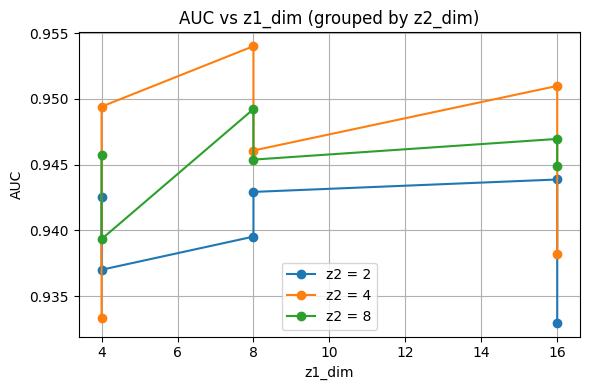

In [97]:
import matplotlib.pyplot as plt

# AUC vs z1_dim
plt.figure(figsize=(6, 4))
for z2 in sorted(df_results['z2_dim'].unique()):
    subset = df_results[df_results['z2_dim'] == z2]
    plt.plot(subset['z1_dim'], subset['auc'], marker='o', label=f'z2 = {z2}')
plt.xlabel("z1_dim")
plt.ylabel("AUC")
plt.title("AUC vs z1_dim (grouped by z2_dim)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [98]:
top = df_results.sort_values(by="auc", ascending=False).head(5)
print("\nTop 5 configurations by AUC:")
print(top)



Top 5 configurations by AUC:
    z1_dim  z2_dim  epochs optimizer       auc
8        8       4     100      adam  0.954019
14      16       4     100      adam  0.950995
3        4       4     200      adam  0.949421
10       8       8     100      adam  0.949232
16      16       8     100      adam  0.946964
